In [1]:
#importing dependencies
import keras
import cv2
import keras.backend as K
from keras.layers import Dense ,Conv2D ,MaxPooling2D ,Dropout ,Flatten ,Activation ,Multiply
from keras.activations import tanh
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint as checkpoint
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score ,recall_score ,f1_score ,roc_auc_score ,confusion_matrix
from keras.models import load_model ,Model

Using TensorFlow backend.


In [2]:
#defining function to load and proces the data from the directory
def load_and_process_data(parent_dir):
    classes = os.listdir(parent_dir)
    no_of_classes = len(classes)
    class_counter = 0
    file_counter = 0
    X_train = []
    Y_train = []
    for folder in classes:
        class_dir = os.path.join(parent_dir ,folder)
        print('class {} is {}'.format(class_counter ,folder))
        for file in os.listdir(class_dir):
            file_counter += 1 
            label = np.zeros([len(classes)])
            label[class_counter] = 1
            final_image = preprocess(os.path.join(class_dir ,file))
            X_train.append(final_image)
            Y_train.append(label)
        class_counter += 1
    print('Found {} images belonging to {} classes'.format(file_counter ,len(classes)))
    X_train = np.asarray(X_train)
    Y_train = np.asarray(Y_train)
    return X_train ,Y_train

In [3]:
#definging a preprocessing function
def preprocess(file):
    image = cv2.imread(file ,cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image = cv2.resize(image ,(224,224))
        image = ((image/255)-0.5)*2
    else:
        print('No such {} exists'.format(file))
    return image.reshape((224 ,224 , 1))

In [4]:
#focal loss for training
def myloss(alpha ,gamma):
    def focal_loss(y_true ,y_pred):
        y_pred = K.clip(y_pred ,1e-8 ,1-1e-8)
        log_lik = y_true*K.log(y_pred)
        loss = alpha*((1-y_pred)**gamma)*log_lik
        return -K.sum(loss)
    return focal_loss
focal_loss = myloss(2.0 ,1.5)

In [5]:
#pretrained efficient net trained on pneumonia cropped dataset(based on segmentation)
encoder = load_model('denoise_encoderv4.h5')

C:\Users\Lenovo\anaconda3\envs\uv\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
#defining attention mechanism
def attention_layer(flatten):
    activation = Activation(tanh ,name = 'myactivation')(flatten)
    activation = Dropout(0.2 ,name = 'dropout')(activation)
    softmax_layer = Dense(2304 ,activation = 'softmax')(activation)
    multiplied =  Multiply(name = 'manoj')([softmax_layer ,flatten])
    return multiplied

In [7]:
#setting all layers to trainable(can be ignored because ,by default everything will be trainable)
for layer in encoder.layers:
    layer.trainable = True

In [8]:
#printing the efficient net summary
encoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [9]:
#building ,compiling ,printing the summary
input_ = encoder.output
print(tf.shape(input_))
Conv_layer = Conv2D(256 ,(3 ,3) ,strides = (2,2) ,kernel_initializer = 'glorot_uniform' ,activation = 'elu',name='conv')(input_)
max_pool = MaxPooling2D((4 ,4) ,name = 'max_pool')(Conv_layer)
flatten = Flatten()(max_pool)
attention_output = attention_layer(flatten)
final_softmax = Dense(3 ,activation = 'softmax')(attention_output)
model = Model(inputs = encoder.input ,outputs = [final_softmax])
model.summary()
model.compile(loss = myloss(2.0 ,1.5) ,optimizer = Adam(lr = 0.000005) ,metrics = ['acc'])

Tensor("Shape:0", shape=(4,), dtype=int32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_2[0][0]                   
_________________________________________________

In [47]:
#loading the data
train_dir = r'D:\COMPUTERS\AI\dataset_and_embeddings\covid_datasets\covid_cropped\train'
valid_dir = r'D:\COMPUTERS\AI\dataset_and_embeddings\covid_datasets\covid_cropped\valid'
test_dir = r'D:\COMPUTERS\AI\dataset_and_embeddings\covid_datasets\covid_cropped\test'
X_train ,Y_train = load_and_process_data(train_dir)
X_test ,Y_test = load_and_process_data(test_dir)
X_valid ,Y_valid = load_and_process_data(valid_dir)

class 0 is covid
class 1 is healthy
class 2 is pneumonia
Found 587 images belonging to 3 classes
class 0 is covid
class 1 is healthy
class 2 is pneumonia
Found 42 images belonging to 3 classes
class 0 is covid
class 1 is healthy
class 2 is pneumonia
Found 31 images belonging to 3 classes


In [48]:
#training and callbacks
filepath="cweights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
callbacks = checkpoint(filepath ,monitor = 'val_acc' ,verbose = 1 ,save_best_only = True ,mode = 'max')
history = model.fit(X_train ,
                    Y_train ,
                    epochs = 60 ,
                    batch_size = 8 ,
                    verbose = 1 ,
                    validation_data = (X_valid ,Y_valid) ,callbacks = [callbacks])

Train on 587 samples, validate on 31 samples
Epoch 1/60
587/587 [==============================] - 21s 36ms/step - loss: 2.9386 - acc: 0.8262 - val_loss: 6.7673 - val_acc: 0.5484

Epoch 00001: val_acc improved from -inf to 0.54839, saving model to cweights-improvement-01-0.5484.hdf5
Epoch 2/60
587/587 [==============================] - 19s 32ms/step - loss: 2.8054 - acc: 0.8279 - val_loss: 6.1747 - val_acc: 0.6129

Epoch 00002: val_acc improved from 0.54839 to 0.61290, saving model to cweights-improvement-02-0.6129.hdf5
Epoch 3/60
587/587 [==============================] - 19s 32ms/step - loss: 2.4795 - acc: 0.8688 - val_loss: 6.4144 - val_acc: 0.6774

Epoch 00003: val_acc improved from 0.61290 to 0.67742, saving model to cweights-improvement-03-0.6774.hdf5
Epoch 4/60
587/587 [==============================] - 21s 35ms/step - loss: 2.4079 - acc: 0.8450 - val_loss: 5.9269 - val_acc: 0.6452

Epoch 00004: val_acc did not improve from 0.67742
Epoch 5/60
587/587 [===========================


Epoch 00042: val_acc did not improve from 0.80645
Epoch 43/60
587/587 [==============================] - 16s 27ms/step - loss: 1.2944 - acc: 0.9250 - val_loss: 3.7542 - val_acc: 0.7742

Epoch 00043: val_acc did not improve from 0.80645
Epoch 44/60
587/587 [==============================] - 16s 27ms/step - loss: 1.1672 - acc: 0.9336 - val_loss: 3.4816 - val_acc: 0.8065

Epoch 00044: val_acc did not improve from 0.80645
Epoch 45/60
587/587 [==============================] - 16s 27ms/step - loss: 1.3630 - acc: 0.9267 - val_loss: 3.5554 - val_acc: 0.7419

Epoch 00045: val_acc did not improve from 0.80645
Epoch 46/60
587/587 [==============================] - 16s 27ms/step - loss: 1.3242 - acc: 0.9216 - val_loss: 3.9791 - val_acc: 0.7742

Epoch 00046: val_acc did not improve from 0.80645
Epoch 47/60
587/587 [==============================] - 16s 27ms/step - loss: 1.1773 - acc: 0.9302 - val_loss: 3.5291 - val_acc: 0.7742

Epoch 00047: val_acc did not improve from 0.80645
Epoch 48/60
587/587

In [49]:
model.load_weights('cweights-improvement-51-0.8387.hdf5')

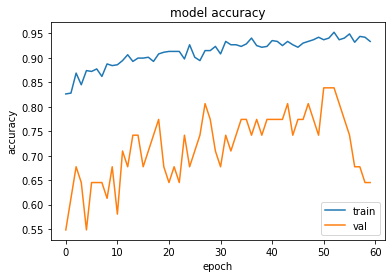

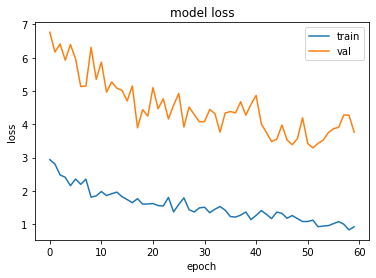

In [50]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [51]:
X_test_ = np.asarray(list(X_test) + list(X_valid))
Y_test_ = np.asarray(list(Y_test) + list(Y_valid))

In [52]:
model.evaluate(X_test_ ,Y_test_)

73/73 [==============================] - 1s 7ms/step


[26.319490680955862, 0.7123287916183472]

In [53]:
#predicting
y_test_pred = model.predict(X_test_)

In [54]:
#converting into classes
final_y_pred = []
final_y_true = []
for i in range(y_test_pred.shape[0]):
    k = np.argmax(y_test_pred[i])
    final_y_pred.append(k+1)
for i in range(Y_test_.shape[0]):
    k = np.argmax(Y_test_[i])
    final_y_true.append(k+1)

[[21  1  1]
 [ 7 14  3]
 [ 2  7 17]]


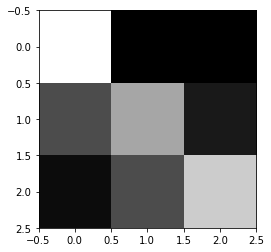

In [55]:
#confusion matrix
k = confusion_matrix(final_y_true ,final_y_pred)
print(k)
plt.imshow(k ,cmap = 'gray')

In [56]:
#acc_score ,pre_score ,recall ,f1
acc_score = accuracy_score(final_y_true ,final_y_pred)
pre_score = precision_score(final_y_true ,final_y_pred ,average = 'micro')
recall = recall_score(final_y_true ,final_y_pred ,average = 'micro')
f1 = f1_score(final_y_true ,final_y_pred ,average = 'micro')

print('accuracy score : {}'.format(acc_score))
print('precision score : {}'.format(pre_score))
print('recall score : {}'.format(recall))
print('f1 score : {}'.format(f1))


accuracy score : 0.7123287671232876
precision score : 0.7123287671232876
recall score : 0.7123287671232876
f1 score : 0.7123287671232877


In [57]:
#printing the model layers
model.layers

In [58]:
#defining grad cam function
def grad_cam(image, cls):
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer('conv').output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (224 ,224), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [59]:
#computing gradcam map for random image
#directories can be adjusted
direc = r'D:\COMPUTERS\AI\dataset_and_embeddings\covid_datasets\cropped2\valid\covid\3.covid-19-pneumonia-2.jpg'
#images = os.listdir(direc)
#img = random.choice(images)
#test_image_dir = os.path.join(direc ,img)
image = preprocess(direc)
cam = grad_cam(image.reshape(1,224,224,1), cls=0)

In [60]:
#predicted class
np.argmax(model.predict(image.reshape(1,224,224,1)))

0

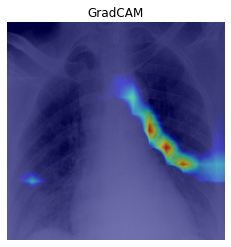

In [61]:
#plotting gradcam
plt.title('GradCAM')
plt.axis('off')
plt.imshow(cv2.resize(cv2.imread(direc),(224,244)))
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.show()

In [137]:
#saving model
model.save('best.h5')